In [1]:
import pandas as pd
import xgboost as xgb
import warnings
import mlflow
import xgboost as xgb
from sklearn.metrics import accuracy_score
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization


warnings.filterwarnings('ignore')

#load data
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#ProfileReport(train, title="Profiling Report")

#drop some vars
drop_list = ['PassengerId', 'Name', 'Cabin']
train = train.drop(drop_list, axis=1)
train = train.dropna(how='any')

print(train.shape)
print(test.shape)

c:\Users\takak\Desktop\spaceship_titanic\venv\Lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\takak\Desktop\spaceship_titanic\venv\Lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
c:\Users\takak\Desktop\spaceship_titanic\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(6923, 11)
(4277, 13)


In [2]:
from sklearn.preprocessing import OneHotEncoder
onehot_list = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Transported']

warnings.filterwarnings('ignore')

# インスタンス化
enc = OneHotEncoder(sparse=False)

for column in onehot_list:
    # OneHotエンコーディングを適用
    transformed = enc.fit_transform(train[[column]])
    
    # エンコーディングされたデータをDataFrameに変換
    transformed_df = pd.DataFrame(transformed, columns=[f"{column}_{cat}" for cat in enc.categories_[0]], index=train.index)  # インデックスを指定
    
    # 元のデータから対象の列を削除
    train = train.drop(column, axis=1)
    
    # エンコーディングされたデータを元のDataFrameに結合
    train = pd.concat([train, transformed_df], axis=1)

train = train.drop(['HomePlanet_Mars', 'Destination_TRAPPIST-1e', 'CryoSleep_False', 'VIP_False', 'Transported_False'], axis=1)
train.head()

#説明変数と被説明変数に分割
x = train.drop(['Transported_True'], axis=1)
y = train['Transported_True']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

train_all = pd.concat([y_train, X_train], axis=1)


#cross varidation
dtrain = xgb.DMatrix(X_train, label=y_train)
params = {'max_depth':3, 'eta':0.1}
cross_val = xgb.cv(
    params, dtrain, num_boost_round=1000, early_stopping_rounds=50
)
best_n_boost_round = cross_val.shape[0]

In [4]:
x.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,Destination_55 Cancri e,Destination_PSO J318.5-22,CryoSleep_True,VIP_True
count,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000
mean,28.891665,226.079590,480.432760,179.328037,318.185035,303.768309,0.539650,0.254658,0.214069,0.094612,0.353748,0.024411
std,14.514540,673.908258,1672.766209,633.614987,1159.247480,1125.448364,0.498461,0.435700,0.410205,0.292700,0.478167,0.154334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,81.500000,29.000000,65.500000,51.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,20336.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'RMSE')

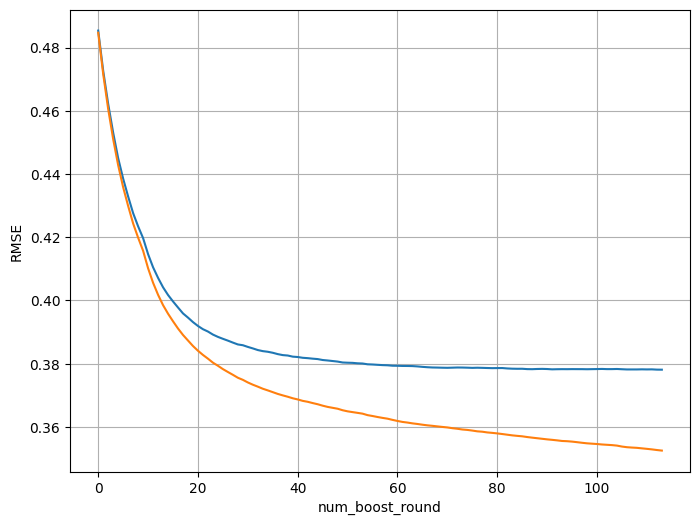

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(cross_val.loc[:, ['test-rmse-mean', 'train-rmse-mean']])
plt.grid()
plt.xlabel('num_boost_round')
plt.ylabel('RMSE')

In [ ]:
parameters = [
    'n_estimators',  # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'max_depth',  # Maximum tree depth for base learners.
    'max_leaves',  # Maximum number of leaves; 0 indicates no limit.
    'max_bin',  # If using histogram-based algorithm, maximum number of bins per feature.
    'grow_policy',  # Tree growing policy.
    'learning_rate',  # Boosting learning rate (xgb's "eta").
    'verbosity',  # The degree of verbosity.
    'objective',  # Specify the learning task and the corresponding learning objective or a custom objective function.
    'booster',  # Specify which booster to use: gbtree, gblinear or dart.
    'tree_method',  # Specify which tree method to use.
    'n_jobs',  # Number of parallel threads used to run xgboost.
    'gamma',  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'min_child_weight',  # Minimum sum of instance weight(hessian) needed in a child.
    'max_delta_step',  # Maximum delta step we allow each tree's weight estimation to be.
    'subsample',  # Subsample ratio of the training instance.
    'sampling_method',  # Sampling method. Used only by the GPU version of "hist" tree method.
    'colsample_bytree',  # Subsample ratio of columns when constructing each tree.
    'colsample_bylevel',  # Subsample ratio of columns for each level.
    'colsample_bynode',  # Subsample ratio of columns for each split.
    'reg_alpha' = 1,  # L1 regularization term on weights (xgb's alpha). LASSO
    'reg_lambda' = 0,  # L2 regularization term on weights (xgb's lambda). Ridge
    'scale_pos_weight',  # Balancing of positive and negative weights.
    'base_score',  # The initial prediction score of all instances, global bias.
    'random_state' = 10,  # Random number seed.
    'missing',  # Value in the data which needs to be present as a missing value.
    'num_parallel_tree',  # Used for boosting random forest.
    'monotone_constraints',  # Constraint of variable monotonicity.
    'interaction_constraints',  # Constraints for interaction representing permitted interactions.
    'importance_type',  # The feature importance type for the feature_importances_ property.
    'device',  # Device ordinal, available options are "cpu", "cuda", and "gpu".
    'validate_parameters',  # Give warnings for unknown parameter.
    'enable_categorical',  # Experimental support for categorical data.
    'feature_types',  # Used for specifying feature types without constructing a dataframe.
    'max_cat_to_onehot',  # A threshold for deciding whether to use one-hot encoding based split for categorical data.
    'max_cat_threshold',  # Maximum number of categories considered for each split.
    'multi_strategy',  # The strategy used for training multi-target models.
    'eval_metric',  # Metric used for monitoring the training result and early stopping.
    'early_stopping_rounds',  # Activates early stopping.
    'callbacks',  # List of callback functions that are applied at end of each iteration.
    'kwargs'  # Keyword arguments for XGBoost Booster object.
]


### 普通に全変数指定して試す(グリッドサーチ)

In [5]:
# 固定パラメータの設定
fixed_params = {
    'grow_policy': 'depthwise',
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'tree_method': 'auto',
    'sampling_method': 'uniform',
    'importance_type': 'gain',
    'device': 'cpu',
    'eval_metric': 'rmse'
}

# パラメータグリッドの定義
param_grid = {
    'max_depth': [3, 10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 1, 2, 3, 4, 5],
    'min_child_weight': [1, 2, 4, 6, 8, 10],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 0.5, 1]
}

# モデルの初期化
model = xgb.XGBClassifier(**fixed_params)

# GridSearchCVの初期化
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1, refit=False)

# 実験の作成
experiment_id = mlflow.create_experiment('spaceship_titanic_grid_search')

# 実験の開始
with mlflow.start_run(run_name='XGBoost_GridSearch', experiment_id=experiment_id):
    # グリッドサーチの実行
    grid_search.fit(X_train, y_train)

    # cv_results_から結果を取得
    results = grid_search.cv_results_

    # 各パラメータセットの結果をログ
    for i in range(len(results['params'])):
        with mlflow.start_run(run_name=f'Run_{i}', nested=True):
            mlflow.log_params(results['params'][i])
            mlflow.log_metric('mean_test_score', results['mean_test_score'][i])
            mlflow.log_metric('std_test_score', results['std_test_score'][i])


### ベイズ最適化による最適ハイパーパラメータ詮索

In [ ]:
#pre setting of categorical parameters
try_grow_policy = 'depthwise'
try_objective = 'reg:squarederror'
try_booster = 'gbtree'
try_tree_method = 'auto'
try_sampling_method = 'uniform'
try_importance_type = 'gain'
try_device = 'cpu'
try_multi_strategy = 'diagonal'
try_eval_metric = 'rmse'

#evaluation function
def xgboost_eval(try_max_depth,try_learning_rate, try_n_estimators, try_gamma, try_min_child_weight, try_subsample, try_colsample_bytree, try_reg_alpha, try_reg_lambda):
    # convert to int since these are not continuous variables
    try_max_depth = int(try_max_depth)
    try_n_estimators = int(try_n_estimators)

    #parameter settings
    #最大値を設定する系はナシ
    #データセットの前処理に関わる変数もナシ。
    model = xgb.XGBClassifier(
        max_depth=try_max_depth,
        learning_rate=try_learning_rate,
        n_estimators=try_n_estimators,
        gamma=try_gamma,
        min_child_weight=try_min_child_weight,
        subsample=try_subsample,
        colsample_bytree=try_colsample_bytree,
        reg_alpha=try_reg_alpha,
        reg_lambda=try_reg_lambda,
        try_grow_policy = try_grow_policy,
        try_objctive = try_objective,
        try_booster = try_booster,
        try_tree_method = try_tree_method,
        try_importance_type = try_importance_type,
        try_device = try_device,
        try_multi_strategy = try_multi_strategy,
        try_eval_metric = try_eval_metric
    )
    
    # model training
    model.fit(X_train, y_train)
    # calculate model score
    score = model.score(X_test, y_test)
    #start logging (nested)
    with mlflow.start_run(run_name = 'XGBoost',
                          experiment_id= experiment,
                          nested = True):
        #logging settings
        mlflow.log_param('max_depth', try_max_depth)
        mlflow.log_param('learning_rate', try_learning_rate)
        mlflow.log_param('n_estimators', try_n_estimators)
        mlflow.log_param('gamma', try_gamma)
        mlflow.log_param('min_child_weight', try_min_child_weight)
        mlflow.log_param('subsample', try_subsample)
        mlflow.log_param('colsample_bytree', try_colsample_bytree)
        mlflow.log_param('reg_alpha', try_reg_alpha)
        mlflow.log_param('reg_lambda', try_reg_lambda)
        mlflow.log_param('grow_policy', try_grow_policy)
        mlflow.log_param('objective', try_objective)
        mlflow.log_param('booster', try_booster)
        mlflow.log_param('tree_method', try_tree_method)
        mlflow.log_param('sampling_method', try_sampling_method)
        mlflow.log_param('importance_type', try_importance_type)
        mlflow.log_param('device', try_device)
        mlflow.log_param('multi_strategy', try_multi_strategy)
        mlflow.log_param('eval_metric', try_eval_metric)
        mlflow.log_metric('score', score)
        mlflow.xgboost.log_model(model,'mdoel')
        
    return score


# set search bounds of each parameter
pbounds = {
    'try_max_depth': (3, 50),
    'try_learning_rate': (0.01, 0.5),
    'try_n_estimators': (100, 1000),
    'try_gamma': (0, 5),
    'try_min_child_weight': (1, 10),
    'try_subsample': (0.5, 1.0),
    'try_colsample_bytree': (0.5, 1.0),
    'try_reg_alpha': (0, 1),
    'try_reg_lambda': (0, 1)
}


#create an experiment
experiment = mlflow.create_experiment('spaceship_titanic_bayes_opt')

#start run experiment
with mlflow.start_run(run_name='XGboost',
                      experiment_id=experiment):
    
    #instansation of optimizer
    optimizer = BayesianOptimization(
        f=xgboost_eval,
        pbounds=pbounds,
        random_state=1
    )
    
    #calculation
    optimizer.maximize(init_points=5, n_iter=95)